In [2]:
import pandas as pd
import numpy as np
import pprint
import requests
import os.path
import json
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from prettytable import PrettyTable
import pickle5 as pickle
from geopandas.tools import sjoin

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "b66466c3-69c8-4825-9c8b-04b270069193"}
package = requests.get(url, params = params).json()
#package["result"]
#pprint.pprint(package["result"])

# Preprocessing Data

### Importing Parking Tickets Dataset into Single DataFrame

In [2]:
file_names = os.listdir("Parking Tickets")
#file_names = ['Parking_Tags_data_2008.csv', 'Parking_Tags_data_2009.csv']
df = pd.DataFrame([])

for csv_file in file_names:
    try:
        temp_df = pd.read_csv('Parking Tickets/'+csv_file, error_bad_lines=False)
    except:
        try:
            temp_df = pd.read_csv('Parking Tickets/'+csv_file, encoding='utf-16', error_bad_lines=False)
        except:
            temp_df = pd.read_csv('Parking Tickets/'+csv_file, error_bad_lines=False, engine="python")
    df = pd.concat([df, temp_df])
    del temp_df


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app
Skipping line 2351360: field larger than field limit (131072)
b'Skipping line 1075521: expected 11 fields, saw 14\n'
b'Skipping line 1413505: expected 11 fields, saw 16\n'
b'Skipping line 170864: expected 11 fields, saw 12\n'
b'Skipping line 181770: expected 11 fields, saw 12\n'


### Importing and Cleaning Green P Parking Data

In [281]:
# with open('Green P Parking/green-p-parking-2015.json') as f:
#     GPParking2015 = json.load(f)

with open('Green P Parking/green-p-parking-2019.json') as f:
    GPParking2019 = json.load(f)
    
# GPParking_dict = {}
# for item in GPParking2019['carparks']:
#     address = item['address']
#     GPParking_dict[address] = item
    
GPParking_df = pd.DataFrame(columns=['address', 'longitude', 'latitude', 'carpark type'])
for item in GPParking2019['carparks']:
    try:
        addr = item['address']
        long = float(item['lng'])
        lat = float(item['lat'])
        carpark_type = item['carpark_type']
    except:
        addr = item['address']
        long = float(item['streetview_long'])
        lat = float(item['streetview_lat'])
        carpark_type = item['carpark_type']
        
    GPParking_df.loc[len(GPParking_df)] = [addr, long, lat, carpark_type]

### Importing and Cleaning TTC Dataset

In [282]:
TTC_df = pd.read_csv('opendata_ttc_schedules/stops.txt')

### Creating New Attributes for Parking Tickets Dataset

In [16]:
# change date column from float to datetime
df['date_of_infraction'] = pd.to_datetime(df['date_of_infraction'], format='%Y%m%d')
# add new column for day of the week
df['month'] = df['date_of_infraction'].dt.month_name().str.slice(stop=3)
# add new column for month
df['weekday'] = df['date_of_infraction'].dt.day_name().str.slice(stop=3)
# add new column for year
df['year'] = df['date_of_infraction'].dt.year
df['year'] = df['year'].astype('str')

# season_dict = {"December": "Winter", "January": "Winter", "February": "Winter", 
#                "March": "Spring", "April": "Spring","May": "Spring", 
#                "June": "Summer", "July": "Summer", "August": "Summer",
#                "September": "Autumn", "October": "Autumn", "November": "Autumn"}
# df['season'] = [season_dict[x] for x in df['month']] # add new column for the season

df['season'] = (df['date_of_infraction'].dt.month%12 + 3)//3
season_dict = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
df['season'] = df['season'].map(season_dict)

### Export/Import Cleaned and Processed .csv File

In [27]:
# export to csv
df.to_csv("Parking_Tickets_Cleaned.csv")

#df.to_pickle("df.pkl")

# import csv
# df = pd.read_csv("Parking_Tickets_Cleaned.csv")

unpickled_df = pd.read_pickle("df.pkl")

In [3]:
df = pd.read_csv("Parking_Tickets_Cleaned.csv")
addr_df = pd.read_hdf('address_df.pkl')

## 3.1 Analysis

#### 3.1.1. Top 20 Infractions by Frequency

In [7]:
# 1. top infractions by freq
top_infractions_freq = df['infraction_code'].value_counts().index.tolist()[0:20]
freq_count = list(df['infraction_code'].value_counts())[0:20]

# create and populate dictionary pairing infraction codes and infraction descriptions
infraction_dict = {}
for code in top_infractions_freq:
    infraction_dict[code] = list(df.loc[df['infraction_code'] == code].infraction_description)[0]

# top infractions by freq name
top_infractions_freq_name = []
for i in top_infractions_freq:
    top_infractions_freq_name.append(infraction_dict[i])

# create new DataFrame with the top 20 infractions by frequency
top_freq_df = df.loc[df['infraction_code'].isin(top_infractions_freq)]
top_freq_df = top_freq_df.loc[top_freq_df['location4'].isna()]

# print out to a table
t = PrettyTable(['Number', 'Infraction Code', 'Infraction Description', 'Frequency'])
for i in range(20):
    t.add_row([i+1, int(top_infractions_freq[i]), top_infractions_freq_name[i], freq_count[i]])
print(t)

+--------+-----------------+--------------------------------+-----------+
| Number | Infraction Code |     Infraction Description     | Frequency |
+--------+-----------------+--------------------------------+-----------+
|   1    |        5        |   PARK HWY PROHIBED TIME/DAY   |  5347742  |
|   2    |        29       | PARK PROHIBITED TIME NO PERMIT |  4306826  |
|   3    |        3        | PARK/LEAVE ON PRIVATE PROPERTY |  3728066  |
|   4    |       210       |  PARK FAIL TO DISPLAY RECEIPT  |  2792373  |
|   5    |       207       | PARK FAIL TO DEP. FEE MACHINE  |  2251445  |
|   6    |        9        |  STOP HWY PROHIBITED TIME/DAY  |  1605315  |
|   7    |        2        |       PARK OVER 3 HOURS        |  1294077  |
|   8    |        8        |  STD VEH HWY PROHIB TIME/DAY   |  1045142  |
|   9    |        6        |  PARK HWY OVER PERMITTED TIME  |   885722  |
|   10   |        15       |   PARK - 3 M OF FIRE HYDRANT   |   414519  |
|   11   |       406       | PARK-VEH.

#### 3.1.2 Top 20 Infractions by Revenue

In [8]:
# 2. top infractions by rev
infraction_rev_dict = {}
for code in df['infraction_code'].unique():
    infraction_rev_dict[sum(df.loc[df['infraction_code'] == code].set_fine_amount)] = code
top_infractions_rev = [infraction_rev_dict[x] for x in sorted(infraction_rev_dict, reverse=True)[:20]]
rev_count = []
for code in top_infractions_rev:
    rev_count.append(int(sum(df.loc[df['infraction_code'] == code].set_fine_amount)))
    
# create and populate dictionary pairing infraction codes and infraction descriptions
for code in top_infractions_rev:
    if code not in infraction_dict.keys():
        infraction_dict[code] = list(df.loc[df['infraction_code'] == code].infraction_description)[0]

# top infractions by rev name
top_infractions_rev_name = []
for i in top_infractions_rev:
    top_infractions_rev_name.append(infraction_dict[i])
    
# create new DataFrame with the top 20 infractions by revenue
top_rev_df = df.loc[df['infraction_code'].isin(top_infractions_rev)]
top_rev_df = top_rev_df.loc[top_rev_df['location4'].isna()]

# print out to a table
t = PrettyTable(['Number', 'Infraction Code', 'Infraction Description', 'Total Revenue'])
for i in range(20):
    t.add_row([i+1, int(top_infractions_rev[i]), top_infractions_rev_name[i], rev_count[i]])
print(t)

+--------+-----------------+--------------------------------+---------------+
| Number | Infraction Code |     Infraction Description     | Total Revenue |
+--------+-----------------+--------------------------------+---------------+
|   1    |        5        |   PARK HWY PROHIBED TIME/DAY   |   220752490   |
|   2    |        29       | PARK PROHIBITED TIME NO PERMIT |   129197850   |
|   3    |        3        | PARK/LEAVE ON PRIVATE PROPERTY |   111839535   |
|   4    |        9        |  STOP HWY PROHIBITED TIME/DAY  |    96310440   |
|   5    |       210       |  PARK FAIL TO DISPLAY RECEIPT  |    83771190   |
|   6    |       207       | PARK FAIL TO DEP. FEE MACHINE  |    67543350   |
|   7    |        8        |  STD VEH HWY PROHIB TIME/DAY   |    62704920   |
|   8    |       347       |      PARK IN A FIRE ROUTE      |    57796530   |
|   9    |       403       | STOP-SIGNED HIGHWAY-RUSH HOUR  |    52327500   |
|   10   |        15       |   PARK - 3 M OF FIRE HYDRANT   |   

#### 3.1.4 Total Revenue Generated

In [562]:
# 4. total revenue for all tickets
print(f"Total Revenue Earned: ${int(sum(df['set_fine_amount']))}")

Total Revenue Earned: $1183667285


### Getting Top 20 Infraction Addresses (By Frequence and Revenue)

In [9]:
# get top 10k addresses according to freq (accounts for 14.7 mil infractions)
top20_addr_freq = top_freq_df['location2'].value_counts().index.tolist()[0:10000]
# get top 10k addresses according to rev ()
top20_addr_rev = top_rev_df['location2'].value_counts().index.tolist()[0:10000]
top20_addr = top20_addr_freq + top20_addr_rev
top20_addr = list(dict.fromkeys(top20_addr))

# new df with only the top 10k addresses
top_freq_df = top_freq_df.loc[top_freq_df['location2'].isin(top20_addr)]
top_rev_df = top_rev_df.loc[top_rev_df['location2'].isin(top20_addr)]

# sum(top_freq_df['location2'].value_counts())

### Access GeoPy Geocoding API to Get Longitude and Latitude Data from Street Addresses

In [ ]:
addr_df = pd.DataFrame(columns=['address', 'location', 'longitude', 'latitude'])
addr_df['address'] = top20_addr
# addr_df['address'] = ['2075 BAYVIEW AVE', '20 EDWARD ST']
addr_df['address']+=", TORONTO, CANADA"

geolocator = Nominatim(user_agent="toronto parking tickets project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
addr_df['location'] = addr_df['address'].apply(geocode)

addr_df['longitude'] = addr_df['location'].apply(lambda loc: tuple(loc.point)[0] if loc else None)
addr_df['latitude'] = addr_df['location'].apply(lambda loc: tuple(loc.point)[1] if loc else None)

# save to pickle
addr_df.pd.to_hdf("address_df.pkl")

# import pickle
addr_df = pd.read_hdf('address_df.pkl')

In [69]:
# create dictionary of addresses with the number of infractions
a = dict(top_freq_df['location2'].value_counts()[0:10000])
b = dict(top_rev_df['location2'].value_counts()[0:10000])
a.update(b) # merge two dictionaries
addr_count_dict = a

# update addr_df with count values
addr_df['Count'] = np.nan
for i in range(len(addr_df)):
    try: 
        addr_df.iloc[i,4] = addr_count_dict[addr_df.iloc[i,0][:-17]]
    except:
        continue
# addr_df = addr_df.dropna()

In [217]:
# update addr_df with revenue values
addr_df['Revenue'] = np.nan
a = top_freq_df.groupby('location2').sum()
for i in range(len(addr_df)):
    try:
        addr_df.iloc[i,5] = a.loc[addr_df.iloc[i,0][:-17]].set_fine_amount
    except:
        continue
# addr_df = addr_df.dropna()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [220]:
addr_df = addr_df.drop(addr_df.loc[addr_df['longitude'] > 44].index)
addr_df = addr_df.drop(addr_df.loc[addr_df['latitude'] < -80].index)
addr_df = addr_df.dropna()

#### 3.1.5a Distance to Closest Parking Lots for Top 20 Infractions

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


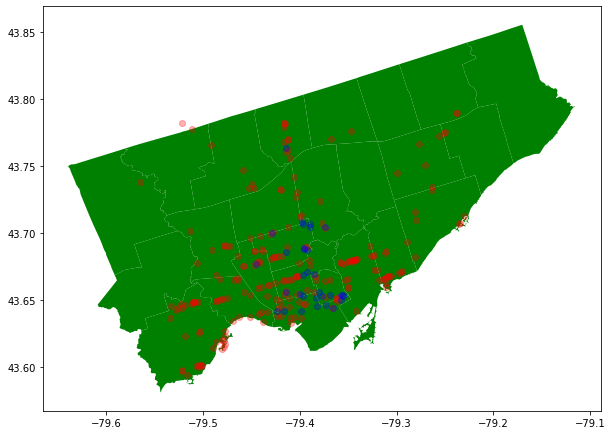

In [283]:
# map of parking lots
wards = gpd.read_file('City Wards/City Wards Data - WGS84.json')

geometry=gpd.points_from_xy(x=GPParking_df.longitude, y=GPParking_df.latitude)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(GPParking_df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(10,10))
wards.plot(ax=ax, color='green')
geo_df[geo_df['carpark type'] == 'surface'].plot(ax=ax, color="red", alpha="0.3")
geo_df[geo_df['carpark type'] == 'garage'].plot(ax=ax, color="blue", alpha="0.3")

#### 3.1.5b Distance to Closest TTC Stop for Top 20 Infractions

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


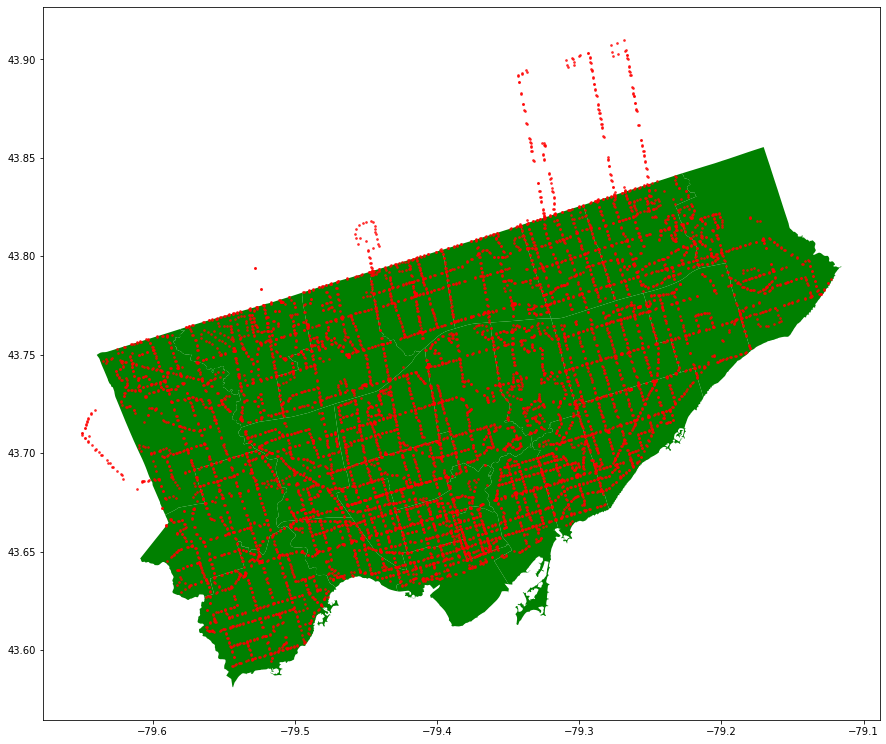

In [284]:
# map of TTC stops
wards = gpd.read_file('City Wards/City Wards Data - WGS84.json')

geometry=gpd.points_from_xy(x=TTC_df.stop_lon, y=TTC_df.stop_lat)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(TTC_df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15,15))
wards.plot(ax=ax, color='green')
geo_df.plot(ax=ax, color="red", alpha="0.7", markersize=3)

#### 3.1.6a Impact of Day of the Week on All Infractions

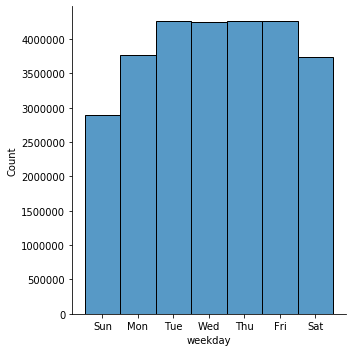

In [563]:
sns.displot(df, x='weekday')

The number of infractions are fairly expected. Weekdays, with the exception of Mondays, get the highest level number of infractions on average than weekends, with Sundays having the lowest number. This could be explained by an increased number of commuter vehicles on the weekdays. The only odd observation is that Mondays are quite low compared to the other weekdays. Perhaps due to a high number of tickets being given to cars parked overnight in prohibited areas. Therefore, since there is likely fewer cars on Sundays, there will be fewer overnight offences caught on the following Monday.

#### 3.1.6b Impact of Month on All Infractions

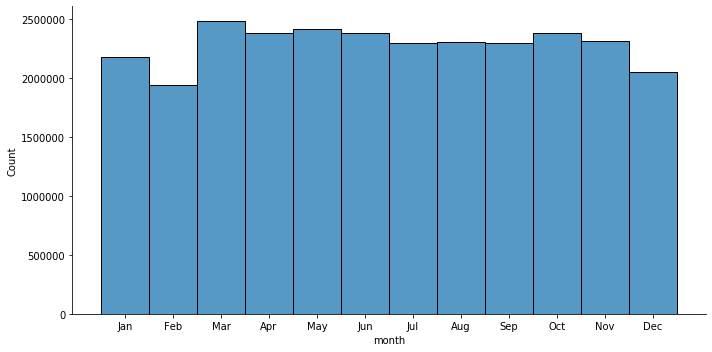

In [564]:
sns.displot(df, x='month', aspect=2)

The clearest observation is decrease in the number of violations in January, December, and February, the winter months. This could be explained in two ways. The first is that there may be fewer cars on the road in the winter months. The second is that the cold weather and snow reduces the mobility of police officers, especially those who are normally on bikes. This may systematically reduce the reporting of the true number of violations.

#### 3.1.6c Impact of Season on All Infractions

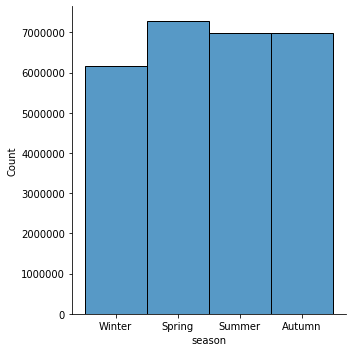

In [565]:
sns.displot(df, x='season')

The distribution of infractions in the seasons shows similar trends to the monthly distribution. This also shows the apparent reduction in infractions in the winter. However, this also shows that there is a spike in infractions in the spring. Reasons for why this differs significantly from summer and autumn, are unknown. 

## 3.3 Visualization

### Distribution Graphs

#### 3.3.1ai Distribution of Infractions by Year

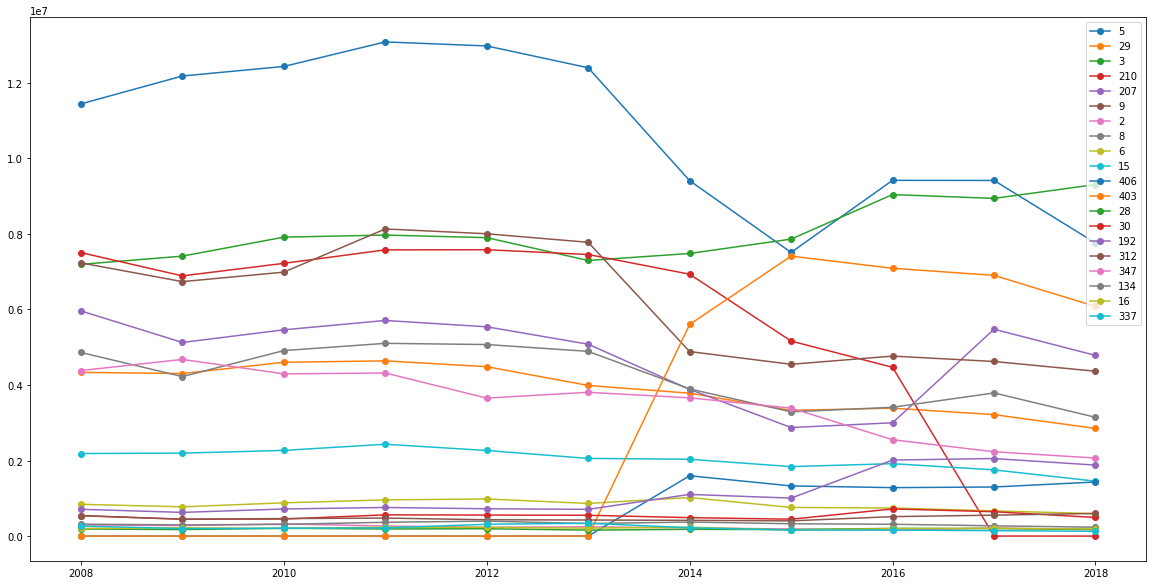

In [259]:
# massaging data for plotting
graph_dict = {}
years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

for code in top_infractions_freq:
    temp_list = []
    temp_df = top_freq_df.loc[top_freq_df['infraction_code'] == code]
    for year in years:
        temp_list.append(sum(temp_df.loc[temp_df['year']==year].set_fine_amount))
    graph_dict[code] = temp_list

# plotting
fig, ax = plt.subplots(figsize=(20,10))
for code in graph_dict.keys():
    ax.plot(years, graph_dict[code], marker='o')
ax.legend([int(x) for x in top_infractions_freq], loc='upper right')
plt.yscale('linear')

From 2008 to 2013, the frequency of infractions for each of the top 20 were quite steady. Code 5 (Park Hwy Prohibited Time/Day) is by far the most common of them. However, beginning in 2014, some new codes were introduced that caused a reduction in some other codes, probably due to them providing more specificity. For example, Code 403 (Stop-Signed Highway-Rush Hour) grew drastically and had the same number of infractions as Code 5 in 2015. From 2014 to 2018, Codes 5, 30 (Stop On/Over Sidewalk/Footpath), and 9 (Stop Hwy Prohibited Time/Day) saw significant reductions. 

#### 3.3.1aii Distribution of Infractions by Month

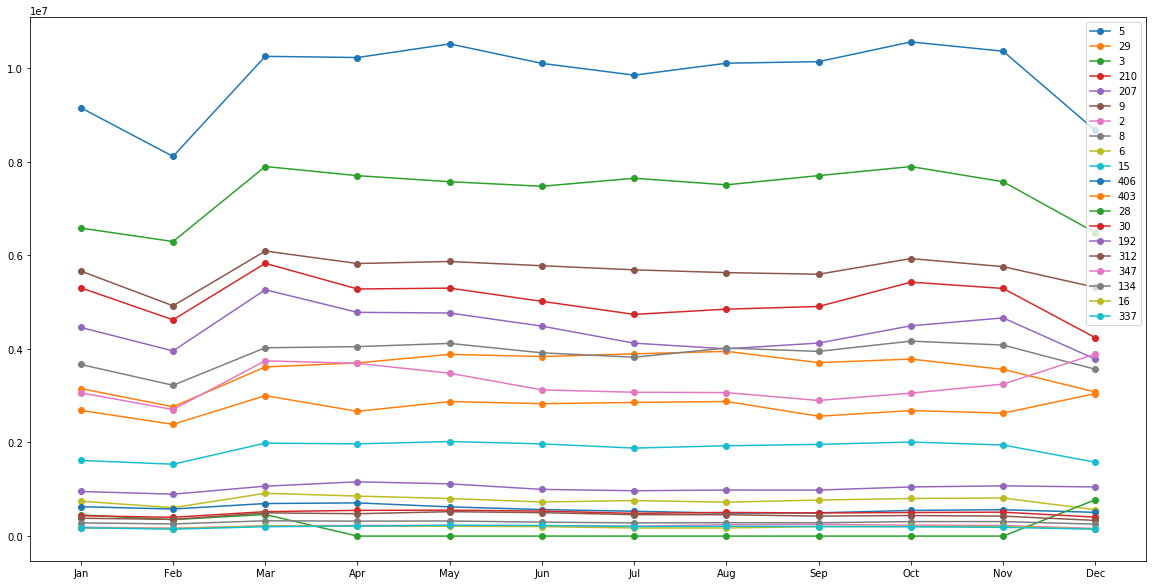

In [262]:
# massaging data for plotting
graph_dict = {}
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for code in top_infractions_freq:
    temp_list = []
    temp_df = top_freq_df.loc[top_freq_df['infraction_code'] == code]
    for month in months:
        temp_list.append(sum(temp_df.loc[temp_df['month']==month].set_fine_amount))
    graph_dict[code] = temp_list

# plotting
fig, ax = plt.subplots(figsize=(20,10))
for code in graph_dict.keys():
    ax.plot(months, graph_dict[code], marker='o')
ax.legend([int(x) for x in top_infractions_freq], loc='upper right')
plt.yscale('linear')

The distribution of the top 20 infractions by month echoes the same findings as the previous monthly graph. Reporting of infractions are consistently decreased in the winter months of December, January, and February for nearly all of the top 20 infractions. There are a few outliers that actually increases from November to December. Additionally, there is very clear division between the top infractions. 

#### 3.3.1b Distribution of Top 20 Infractions by Total Ticket Fines

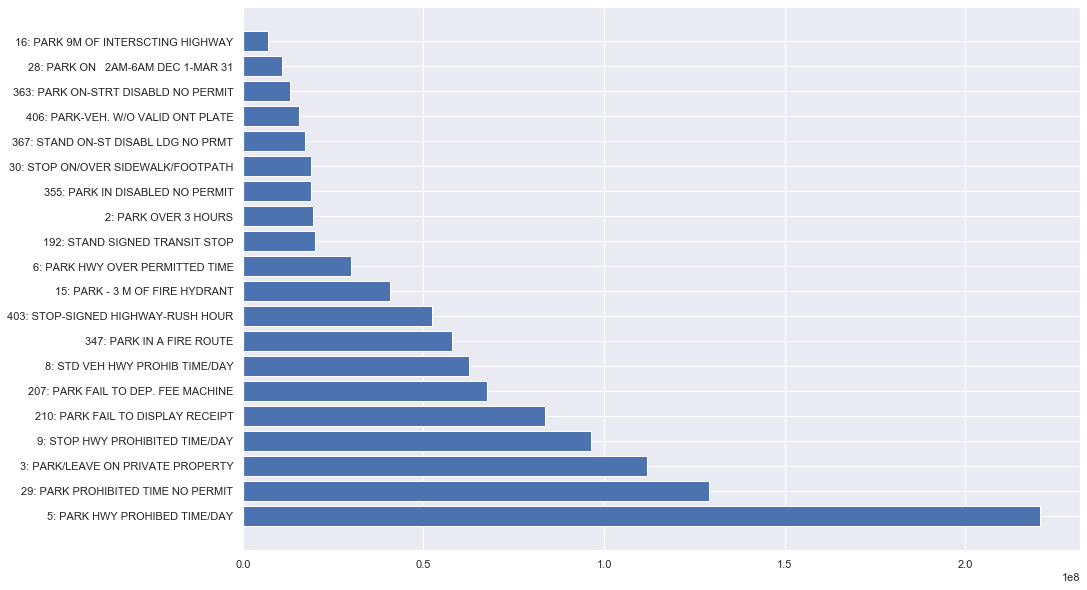

In [668]:
# distribution graphs
fig, ax = plt.subplots(figsize=(15,10))
label = [f"{int(top_infractions_rev[i])}: {top_infractions_rev_name[i]}" for i in range(20)]

y_pos = np.arange(len(label))
ax.barh(y_pos, rev_count)
ax.set_yticks(y_pos)
ax.set_yticklabels(label)

plt.show()

Out of the top 20 earning infractions, Code 5 collects the most by a large margin, with nearly double the next largest. It also appears to be a division between the top 10 and top 20 to 11 infractions. There are big jumps and differences between infractions in the top 10, whereas the bottom 10 are fairly close revenue-wise. 

### Geographic Plots

#### 3.3.2a Geographic Distribution of Top 20 Infractions by Location

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


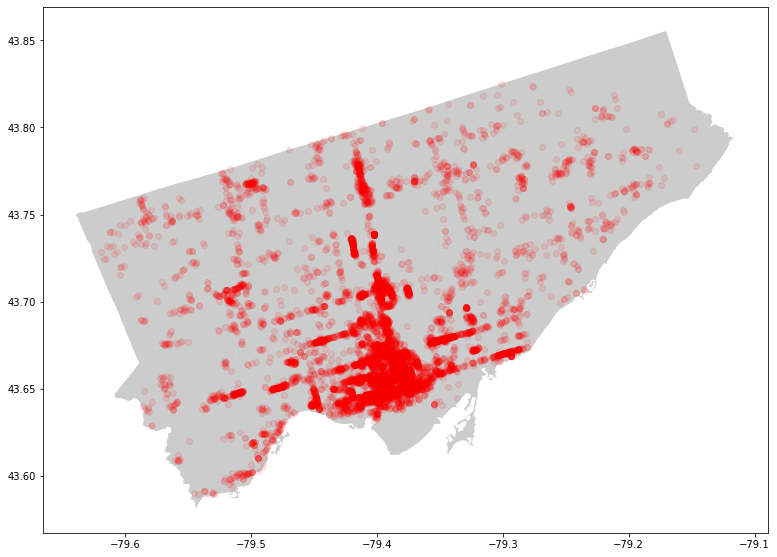

In [255]:
wards = gpd.read_file('City Wards/City Wards Data - WGS84.json')
geometry=gpd.points_from_xy(x=addr_df.latitude, y=addr_df.longitude)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(addr_df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(13,13))
wards.plot(ax=ax, color='grey', alpha=0.4)
geo_df.plot(ax=ax, color="red", alpha=0.1)

This geographical map clearly shows a high prevalence of infractions in the downtown metropolitan area. Additionally, the number of overlapping points map out some of the large main streets in Toronto that accounts for a large number of infractions. For example, the thick vertical line near the middle represents Yonge street. 

#### 3.3.2b Geographic Distribution of Top 20 Infractions by Count by Ward

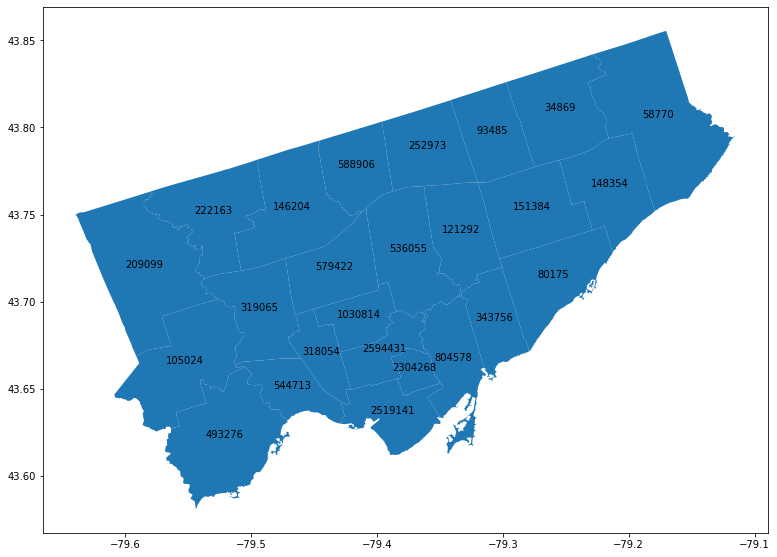

In [199]:
# add count numbers to each ward
wards['Count'] = np.zeros(25)
for i, row1 in addr_df.iterrows():
    a = Point(row1['latitude'], row1['longitude'])
    count = row1['Count']
    for j, row2 in wards.iterrows():
        if a.within(row2['geometry']):
            wards['Count'][j] += count
            break
wards['Count'] = wards['Count'].astype('int32')

# plot map with labels
ax = wards.plot(figsize=(13,13))
wards.apply(lambda x: ax.annotate(s=x.Count, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

This geographical map shows the number of infractions in each ward of Toronto. This further corroborates the finding that downtown Toronto accounts for the majority of infractions. Most of the downtown wards contain well over 1 million infractions, whereas the wards outide of downtown don't come close to 1 million infractions. 

#### 3.3.2c Geographic Distribution of Top 20 Infractions by Sum fines by Ward

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


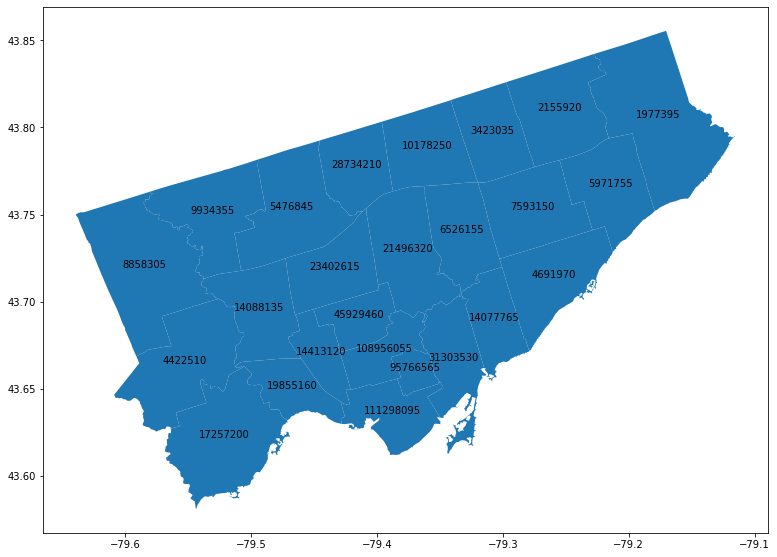

In [254]:
# add count numbers to each ward
wards['Revenue'] = np.zeros(25)
for i, row1 in addr_df.iterrows():
    a = Point(row1['latitude'], row1['longitude'])
    count = row1['Revenue']
    for j, row2 in wards.iterrows():
        if a.within(row2['geometry']):
            wards['Revenue'][j] += count
            break
wards['Revenue'] = wards['Revenue'].astype('int32')

# plot map with labels
ax = wards.plot(figsize=(13,13))
wards.apply(lambda x: ax.annotate(s=x.Revenue, xy=x.geometry.centroid.coords[0], ha='center'),axis=1);

This figure is highly reflective of the last one. The same conclusions can be drawn, but simply with different numbers. This again shows that the downtown area earns the most revenue from infractions out of all the other wards. The downtown wards earn up to $100 million in fines each, whereas the other wards only earn in the tens of millions. 